In [1]:
# In your Jupyter Notebook cell
import pandas as pd
import numpy as np
import joblib
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# We need to import our PyTorch model classes to be able to load the models
# We add the 'src' folder to our system path to make this possible
import sys
sys.path.append('../src')
from pytorch_utils import LSTMModel, TransformerModel

# Set some plotting defaults
%matplotlib inline
sns.set_context('talk') # Makes plots bigger and more readable

# Model Benchmarking for Hypothesis A

**Hypothesis:** The characteristics of the Asian session contain predictive information about the directional outcome of the subsequent London session.

**Objective:** This notebook compares the performance of three different classification models trained on data from 2018-present to select a single "champion" model for backtesting.

**Models Under Review:**
1.  **XGBoost Classifier:** A tree-based model using summary features.
2.  **LSTM Classifier:** A recurrent neural network using sequential data.
3.  **Transformer Classifier:** An attention-based network using sequential data.

In [23]:
# --- Load Test Data ---
# We need the original test sets to make predictions
# First, the tabular data for XGBoost
df_features = pd.read_parquet('../data/processed/hyp_a_features_xauusd_h1_2018_present.parquet')
train_size = int(len(df_features) * 0.8)
test_df = df_features.iloc[train_size:]
X_test_xgb = test_df.drop(columns=['london_direction', 'london_return', 'timeframe', 'symbol'])
y_test_xgb = test_df['london_direction'] # The true labels are the same for all models

# Next, the sequential data for the DL models
X_test_dl = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_sequences_X_padded.npy')
y_test_dl = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_targets_y_class.npy')

# We need to apply the same train/test split to get the correct slice
# Note: We must use the same random_state to ensure the split is identical!
from sklearn.model_selection import train_test_split
_, X_test_dl, _, y_test_dl = train_test_split(X_test_dl, y_test_dl, test_size=0.2, random_state=42)

# --- Load Trained Models ---
print("Loading trained models...")
# 1. XGBoost
xgb_model = joblib.load('../models/xgb_classifier_hyp_a_xauusd_h1_2018_present.joblib')

# 2. LSTM
# First, initialize the model structure
lstm_model = LSTMModel(input_size=X_test_dl.shape[2], hidden_size=50, output_size=1)
# Then, load the saved weights
lstm_model.load_state_dict(torch.load('../models/hyp_a_xauusd_h1_2018_pytorch_lstm_classifier.pth'))
lstm_model.eval() # Set to evaluation mode

# 3. Transformer
# Initialize the model structure
transformer_model = TransformerModel(input_size=X_test_dl.shape[2], hidden_size=32, nhead=4, nlayers=2, output_size=1)
# Load the saved weights
transformer_model.load_state_dict(torch.load('../models/hyp_a_xauusd_h1_2018_pytorch_transformer_classifier.pth'))
transformer_model.eval()

print("All models and test data loaded successfully.") 

Loading trained models...
All models and test data loaded successfully.


In [24]:
len(y_test_xgb), len(y_test_dl)

(397, 399)

In [7]:
df_features

,day_of_week,asia_return,asia_range,atr_at_asia_close,rsi_at_asia_close,ema50_dist,ema200_dist,london_direction,london_return,timeframe,symbol
date,,,,,,,,,,,
2018-01-15,0,0.005629,8.68,2.664710,76.767280,0.010549,0.018260,0,-0.002151,h1,xauusd
2018-01-16,1,0.001135,4.11,2.135934,56.859165,0.003920,0.013381,0,-0.006220,h1,xauusd
2018-01-17,2,-0.003264,10.02,2.947149,41.565265,-0.001740,0.006212,1,0.000997,h1,xauusd
2018-01-18,3,-0.000324,6.27,3.006143,42.778712,-0.003702,0.000870,1,0.001731,h1,xauusd
2018-01-19,4,0.002190,6.97,2.545249,55.094778,0.000468,0.002878,1,0.001953,h1,xauusd
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15,0,0.000266,20.14,6.843659,53.301510,0.001228,0.014456,1,0.001141,h1,xauusd
2025-09-16,1,0.002015,14.72,7.797400,65.886681,0.007152,0.020984,1,0.002206,h1,xauusd
2025-09-17,2,-0.002680,20.93,7.032766,46.576228,0.001180,0.015342,0,-0.000845,h1,xauusd


In [8]:
X_test_xgb

,day_of_week,asia_return,asia_range,atr_at_asia_close,rsi_at_asia_close,ema50_dist,ema200_dist
date,,,,,,,
2024-03-08,4,-0.001056,9.63,4.567756,55.659097,0.004943,0.028385
2024-03-11,0,-0.001504,12.24,6.300610,55.930642,0.005979,0.029987
2024-03-12,1,-0.002384,10.48,4.591051,45.451955,0.000960,0.022644
2024-03-13,2,0.001289,5.83,4.916833,41.555910,-0.003260,0.011579
2024-03-14,3,-0.001694,8.36,3.752305,47.347090,-0.000098,0.012355
...,...,...,...,...,...,...,...
2025-09-15,0,0.000266,20.14,6.843659,53.301510,0.001228,0.014456
2025-09-16,1,0.002015,14.72,7.797400,65.886681,0.007152,0.020984
2025-09-17,2,-0.002680,20.93,7.032766,46.576228,0.001180,0.015342


### **Generate Predictions for all Models**

In [25]:
# --- Generate Predictions ---
print("Generating predictions for all models...")

# 1. XGBoost Predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# 2. & 3. Deep Learning Predictions (requires a helper function)
def get_dl_predictions(model, data):
    # Convert numpy data to PyTorch tensors
    tensor_data = torch.tensor(data, dtype=torch.float32)
    predictions = []
    with torch.inference_mode():
        outputs = model(tensor_data).squeeze()
        predicted_probs = torch.sigmoid(outputs)
        predicted_labels = torch.round(predicted_probs)
        predictions = predicted_labels.cpu().numpy()
    return predictions

y_pred_lstm = get_dl_predictions(lstm_model, X_test_dl)
y_pred_transformer = get_dl_predictions(transformer_model, X_test_dl)

print("Predictions generated.")

Generating predictions for all models...
Predictions generated.


### **Grand Comparison - Visualization and Reports**

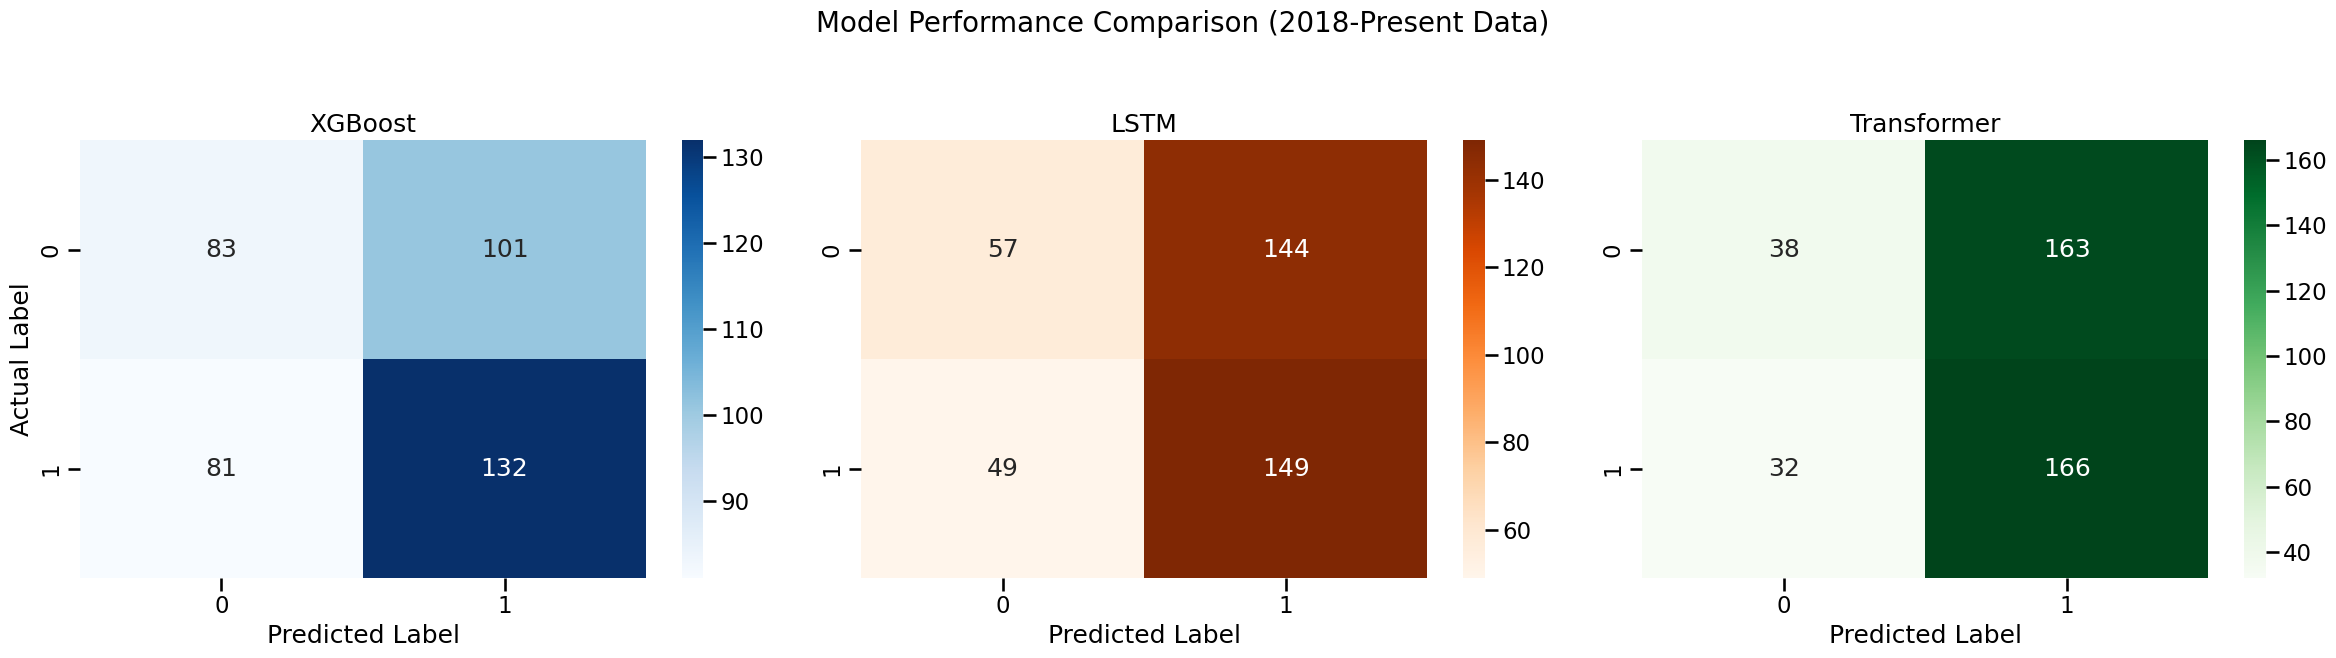

============================== XGBoost Report ==============================
              precision    recall  f1-score   support

     Bearish       0.51      0.45      0.48       184
     Bullish       0.57      0.62      0.59       213

    accuracy                           0.54       397
   macro avg       0.54      0.54      0.53       397
weighted avg       0.54      0.54      0.54       397


============================== LSTM Report ==============================
              precision    recall  f1-score   support

     Bearish       0.54      0.28      0.37       201
     Bullish       0.51      0.75      0.61       198

    accuracy                           0.52       399
   macro avg       0.52      0.52      0.49       399
weighted avg       0.52      0.52      0.49       399


============================== Transformer Report ==============================
              precision    recall  f1-score   support

     Bearish       0.54      0.19      0.28       201
   

In [26]:
# --- Create a comparison figure ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Model Performance Comparison (2018-Present Data)', fontsize=20)

# 1. XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('XGBoost')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# 2. LSTM Confusion Matrix
cm_lstm = confusion_matrix(y_test_dl, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('LSTM')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('') # Hide y-label for clarity

# 3. Transformer Confusion Matrix
cm_transformer = confusion_matrix(y_test_dl, y_pred_transformer)
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Transformer')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('') # Hide y-label for clarity

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Print Classification Reports for Comparison ---
print("="*30 + " XGBoost Report " + "="*30)
print(classification_report(y_test_xgb, y_pred_xgb, target_names=['Bearish', 'Bullish']))

print("\n" + "="*30 + " LSTM Report " + "="*30)
print(classification_report(y_test_dl, y_pred_lstm, target_names=['Bearish', 'Bullish']))

print("\n" + "="*30 + " Transformer Report " + "="*30)
print(classification_report(y_test_dl, y_pred_transformer, target_names=['Bearish', 'Bullish']))

## Analysis and Conclusion

After evaluating all three models on the test set from the 2018-present data, a clear winner emerges.

### Key Findings:
1.  **Overall Accuracy:** The **XGBoost model achieved the highest accuracy of 54%**, outperforming both the LSTM (52%) and the Transformer (50%).
2.  **Signal Quality (Precision):** For predicting a "Bullish" day, the XGBoost model had the highest precision (57%). This indicates its "buy" signals are the most reliable. The Transformer, in particular, showed a strong bullish bias, resulting in very poor precision.
3.  **Model Behavior:** The XGBoost model demonstrates the most balanced performance, correctly identifying a reasonable number of both bullish and bearish days. The deep learning models, especially the Transformer, tended to develop a strong bias towards predicting the majority class in the dataset.

### Final Decision:

Based on its superior accuracy and more balanced, reliable predictions, the **XGBoost Classifier is selected as the champion model**. This model will be carried forward into the final backtesting phase to determine if its statistical edge can be translated into a profitable trading strategy.